In [1]:
from dataset import NYUDEPTHV2
from model import UNet
from loss import mde_loss
from utils import test_model
from utils import predict
from utils import preprocess_fn

import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader



/home/nurbano/miniconda3/envs/FastDepth/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#folder = "train"
folder = "val/official"
root = "/media/nurbano/Datos7/Datasets/nyudepthv2"

In [3]:
path = root + "/" + folder 

filelist = []

for root, dirs, files in os.walk(path):
    for file in files:
        filelist.append(os.path.join(root, file))

filelist.sort()
data = {
    "h5": [x for x in filelist if x.endswith(".h5")]
}

df = pd.DataFrame(data)
df.head()

,h5
0,/media/nurbano/Datos7/Datasets/nyudepthv2/val/...
1,/media/nurbano/Datos7/Datasets/nyudepthv2/val/...
2,/media/nurbano/Datos7/Datasets/nyudepthv2/val/...
3,/media/nurbano/Datos7/Datasets/nyudepthv2/val/...
4,/media/nurbano/Datos7/Datasets/nyudepthv2/val/...


In [4]:
#Take a 50k split of the dataset
#df2=df.sample(n=50000, replace=True).reset_index(drop="true")
df2= df

In [5]:
tran_test = transforms.Compose([transforms.Resize([224,224])])

dset_test = NYUDEPTHV2(path, df2.reset_index(drop="true"),  transform = tran_test, transform2 = None)
#dset_test = NYUDEPTHV2(path, df2[int(df2.h5.size*0.99):].reset_index(drop="true"),  transform = tran_test, transform2 = None)

In [6]:
len(dset_test)

654

In [7]:
test_dataloader= DataLoader(dset_test, batch_size=32, shuffle=True, num_workers=12)

torch.Size([3, 224, 224]) torch.Size([1, 224, 224]) tensor(1.7765) tensor(0.2377) torch.float32 torch.float32


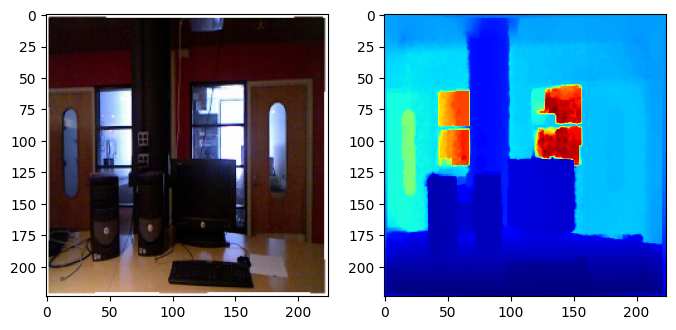

In [8]:
im, de = dset_test[10]
print(im.shape, de.shape, de.max(), de.min(), im.dtype, de.dtype)

cmap = plt.get_cmap("jet").copy()
cmap.set_bad(color="black")
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow((im.squeeze().permute(1,2,0) + 1.0)/2.0)
ax[1].imshow((de.squeeze() + 1.0)/2.0, cmap= cmap)

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [10]:
model = UNet().to(device)

In [11]:
PATH_MODEL= "/home/nurbano/Dropbox/depht_estimation/model/mde_v1.pth"
PATH_MODEL= "model.pth"


In [12]:
checkpoint = torch.load(PATH_MODEL)
model.load_state_dict(checkpoint, strict= False)

<All keys matched successfully>

In [13]:
model.eval()
PATH_MODEL

'model.pth'

In [14]:
rmse = test_model(model, test_dataloader, device)
print("Test: ", "RMSE: ",rmse)

/home/nurbano/miniconda3/envs/FastDepth/lib/python3.12/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Test:  RMSE:  1.0885112285614014


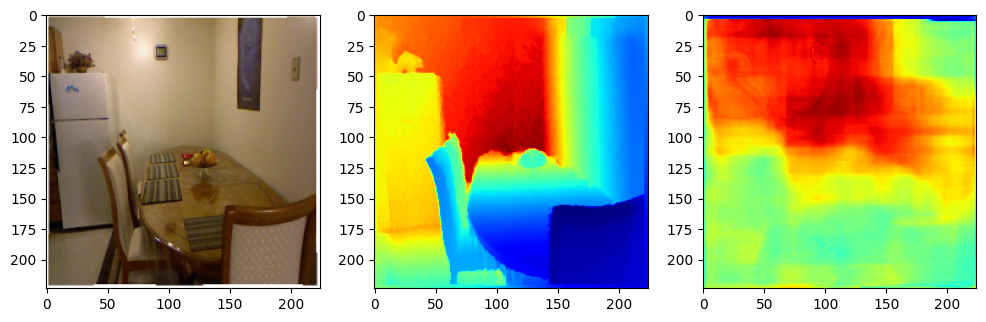

In [15]:
im, dm = dset_test[230]
de_p=predict(im, model, device)
cmap = plt.get_cmap("jet").copy()
cmap.set_bad(color="black")
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow((im.permute(1,2,0) + 1.0)/2.0)
ax[1].imshow((dm.squeeze() + 1.0)/2.0, cmap= cmap)
ax[2].imshow((de_p.squeeze() + 1.0)/2.0, cmap= cmap)


In [16]:
FPS= []
DEVICE= []

## Inference on GPU

In [17]:
device="cuda:0"
dummy_input = torch.randn(1, 3,224,224).to(device)
model.to(device)
# INIT LOGGERS
starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
repetitions = 10
timings=np.zeros((repetitions,1))
#GPU-WARM-UP
for _ in range(10):
    _ = model(dummy_input)
# MEASURE PERFORMANCE
with torch.no_grad():
    for rep in range(repetitions):
        starter.record()
        _ = model(dummy_input)
        ender.record()
        # WAIT FOR GPU SYNC
        torch.cuda.synchronize()
        curr_time = starter.elapsed_time(ender)
        timings[rep] = curr_time

mean_syn = np.sum(timings) / repetitions
std_syn = np.std(timings)
print(mean_syn/1000)
print("FPS:", 1000/mean_syn)
FPS.append(1000/mean_syn)
DEVICE.append("GPU")

0.0025575616598129272
FPS: 390.99741590321815


## Inference on CPU

In [18]:
import time
device= "cpu"
dummy_input = torch.randn(1, 3,224,224, dtype=torch.float).to(device)
model.to(device)

repetitions = 1
timings=np.zeros((repetitions,1))
#GPU-WARM-UP
for _ in range(10):
    _ = model(dummy_input)
# MEASURE PERFORMANCE
with torch.no_grad():
    for rep in range(repetitions):
        st = time.time()
        _ = model(dummy_input)
        et = time.time()
        # WAIT FOR GPU SYNC

        curr_time = et-st
        timings[rep] = curr_time

mean_syn = np.sum(timings) / repetitions
std_syn = np.std(timings)
print(mean_syn)
print("FPS:", 1/mean_syn)

FPS.append(1/mean_syn)
DEVICE.append("CPU")

0.032387495040893555
FPS: 30.876114337875343


Text(0.5, 1.0, 'Inference')

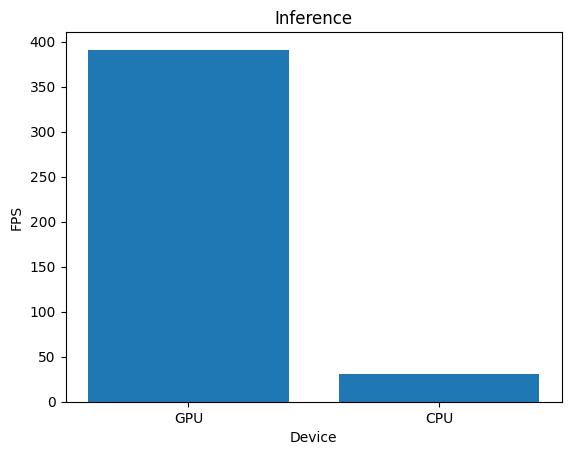

In [19]:
plt.bar(DEVICE,FPS)
plt.xlabel("Device")
plt.ylabel("FPS")
plt.title("Inference")

In [20]:
img_path= "/home/nurbano/Dropbox/depht_estimation/hogar_casa.jpg"

## Infer a custom image

In [21]:
from PIL import Image

In [22]:
im = np.array(Image.open(img_path).resize((224,224)), dtype=np.float32)
im = np.transpose(im, (2, 0, 1))
im = (im - np.min(im))/(np.max(im) - np.min(im))
im = (im - 0.5)*2.0
im = torch.from_numpy(im[0:3])

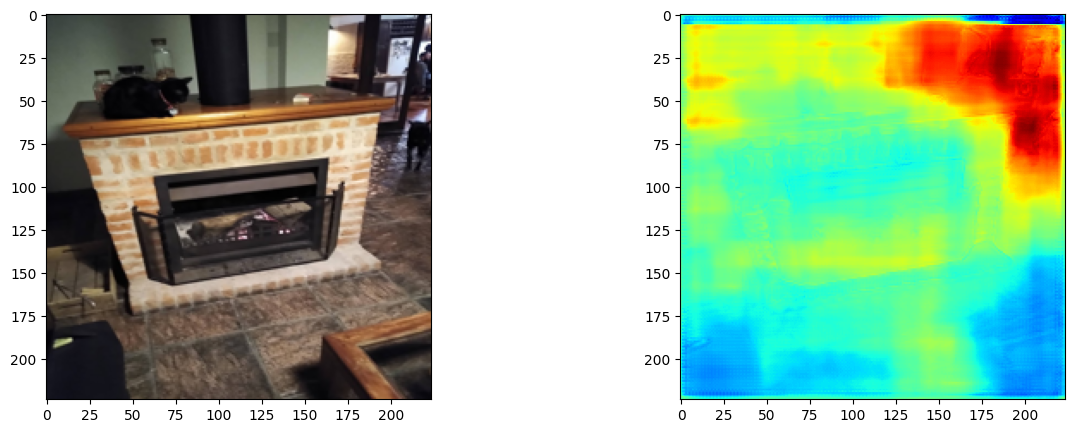

In [23]:
de_p=predict(im, model, device)
cmap = plt.get_cmap("jet").copy()
cmap.set_bad(color="black")
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow((im.permute(1,2,0) + 1.0)/2.0)

ax[1].imshow((de_p.squeeze() + 1.0)/2.0, cmap= cmap)

In [24]:
from IPython import display
import cv2

In [25]:
np.asarray(im.squeeze()).shape

(3, 224, 224)

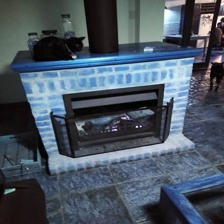

In [26]:
_,ret_array = cv2.imencode('.jpg', np.asarray((((im/2)+0.5)*255).squeeze()).transpose((1,2,0)) )
i= display.Image(data=ret_array)
display.display(i)